# Chapter 5 - Indoor Scene Classification with TFLu and the Arduino Nano

In [44]:
# %tensorflow_version 2.x

### Python libraries

In [45]:
import numpy as np
import pathlib
#!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python
import tensorflow as tf
#import tensorflow_datasets as tfds
import zipfile
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

### Constants

In [46]:
MODEL_ALPHA = 0.35
MODEL_INPUT_WIDTH = 64
MODEL_INPUT_HEIGHT = 64
TFL_MODEL_FILE = "temp.tflite"
TFL_MODEL_HEADER_FILE = "temp_model.h"
TF_MODEL = "temp"

## Transfer learning with Keras

### Unzip the dataset (dataset.zip) SKIP THIS STEP


In [47]:
# with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
#   zip_ref.extractall(".")
# data_dir = "dataset"

### Prepare the train (80%) and validation (20%) datasets

In [48]:
data_dir="edited_dataset"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  interpolation="bilinear",
  image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT)
  )

Found 145 files belonging to 3 classes.
Using 116 files for training.
Found 145 files belonging to 3 classes.
Using 29 files for validation.


### Get the name of the classes

In [49]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['paper', 'rock', 'scissors']


### Rescale the pixel values from [0, 255] to [-1, 1]

In [50]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset= -1)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds   = val_ds.map(lambda x, y: (rescale(x), y))

### Import the MobileNet v2 pre-trained model

In [51]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet_v2.py
base_model = MobileNetV2(input_shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3),
                         include_top=False,
                         weights='imagenet',
                         alpha=MODEL_ALPHA)
base_model.trainable = True

feat_extr = base_model

### Augment the input data

In [52]:
augmen = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  #tf.keras.layers.experimental.preprocessing.RandomZoom(0.1, 0.1),
  # tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

train_ds = train_ds.map(lambda x, y: (augmen(x), y))
# val_ds   = val_ds.map(lambda x, y: (augmen(x), y))

### Prepare the classification head

In [53]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

### Build the model architecture

In [54]:
inputs = tf.keras.Input(shape=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT, 3))
x = global_avg_layer(feat_extr.layers[-1].output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = dense_layer(x)
model = tf.keras.Model(inputs=feat_extr.inputs, outputs=outputs)

### Compile the model with a 0.0005 learning rate

In [55]:
lr = 0.0001
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

### Model summary

In [56]:
# model.summary()

### Train the model with 10 epochs

In [57]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=100
)

Epoch 1/100
4/4 [==============================] - 30s 924ms/step - loss: 1.7311 - accuracy: 0.2759 - val_loss: 1.3973 - val_accuracy: 0.2414
Epoch 2/100
4/4 [==============================] - 2s 472ms/step - loss: 1.2908 - accuracy: 0.4569 - val_loss: 1.3478 - val_accuracy: 0.3103
Epoch 3/100
4/4 [==============================] - 1s 251ms/step - loss: 1.3570 - accuracy: 0.4397 - val_loss: 1.2858 - val_accuracy: 0.3103
Epoch 4/100
4/4 [==============================] - 1s 230ms/step - loss: 1.2951 - accuracy: 0.4655 - val_loss: 1.2192 - val_accuracy: 0.3793
Epoch 5/100
4/4 [==============================] - 1s 212ms/step - loss: 1.1956 - accuracy: 0.4828 - val_loss: 1.1456 - val_accuracy: 0.4483
Epoch 6/100
4/4 [==============================] - 1s 211ms/step - loss: 1.1042 - accuracy: 0.5000 - val_loss: 1.0810 - val_accuracy: 0.5172
Epoch 7/100
4/4 [==============================] - 1s 219ms/step - loss: 0.8705 - accuracy: 0.6121 - val_loss: 1.0456 - val_accuracy: 0.5172
Epoch 8/100


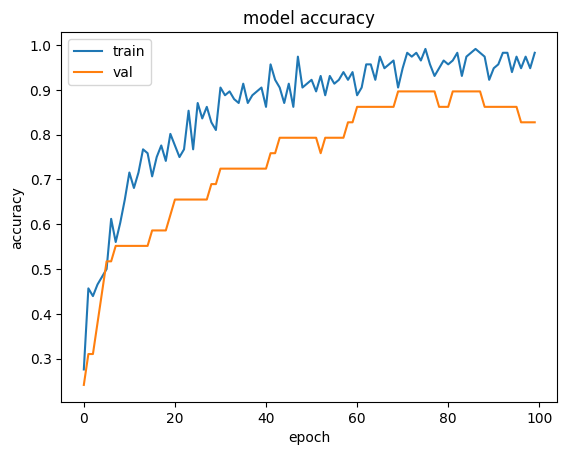

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

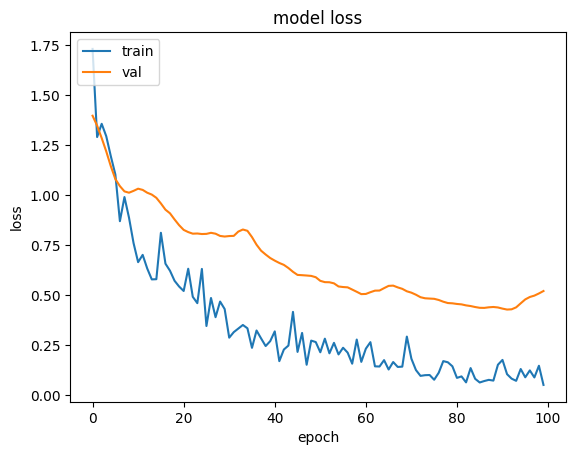

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
# model_copy=tfmot.quantization.keras.quantize_model(model)
# model_copy.compile(
#   optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
#   loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
#   metrics=['accuracy'])
# history=model_copy.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=10
# )

### Save the TensorFlow model

In [61]:
model.save(TF_MODEL)

INFO:tensorflow:Assets written to: temp/assets


INFO:tensorflow:Assets written to: temp/assets


## Preparing and testing the quantized TFLite model

### Unzip the test dataset (test_samples.zip)

In [62]:
# with zipfile.ZipFile("test_samples.zip", 'r') as zip_ref:
#     zip_ref.extractall(".")
# test_dir = "dataset"

### Rescale the pixel values from [0, 255] to [-1, 1]

In [63]:
test_dir="edited_dataset"
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      interpolation="bilinear",
                                                      image_size=(MODEL_INPUT_WIDTH, MODEL_INPUT_HEIGHT))
test_ds  = test_ds.map(lambda x, y: (rescale(x), y))

Found 145 files belonging to 3 classes.


### Quantize the TensorFlow model with the TFLite converter

In [64]:
repr_ds = test_ds.unbatch()

def representative_data_gen():
  for i_value, o_value in repr_ds.batch(1).take(48):
    yield [i_value]

converter = tf.lite.TFLiteConverter.from_saved_model(TF_MODEL)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8

tfl_model = converter.convert()

2023-07-12 10:54:52.820176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-07-12 10:54:52.825567: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-07-12 10:54:52.837153: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: temp
2023-07-12 10:54:52.884054: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-12 10:54:52.884145: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: temp
2023-07-12 10:54:53.439938: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-07-12 10:54:57.608377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: F

### Get the TFLite model size in bytes

In [65]:
size_tfl_model = len(tfl_model)
print(len(tfl_model), "bytes")

619216 bytes


### Initialize the TFLite interpreter

In [66]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_content=tfl_model)

# Allocate the tensors
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Get input quantization parameters

In [67]:
# Get input/output layer information
i_details = interpreter.get_input_details()[0]
o_details = interpreter.get_output_details()[0]

# Get input quantization parameters.
i_quant = i_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]

### Evaluate the accuracy of the quantized TFLite model

In [68]:
test_ds0 = val_ds.unbatch()

num_correct_samples = 0
num_total_samples   = len(list(test_ds0.batch(1)))

for i_value, o_value in test_ds0.batch(1):
  i_value = (i_value / i_scale) + i_zero_point
  i_value = tf.cast(i_value, dtype=tf.int8)
  interpreter.set_tensor(i_details["index"], i_value)
  interpreter.invoke()
  o_pred = interpreter.get_tensor(o_details["index"])[0]

  if np.argmax(o_pred) == o_value:
    num_correct_samples += 1

print("Accuracy:", num_correct_samples/num_total_samples)

Accuracy: 0.8620689655172413


### Convert the TFLite model to C-byte array with xxd

In [69]:
open("model.tflite", "wb").write(tfl_model)
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i model.tflite > model64v1.cpp

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)


: 